# Image Posterization using K-means Clustering Algorithm

In [1]:
#import PIL as pil
from PIL import Image
from skimage import io
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import joblib

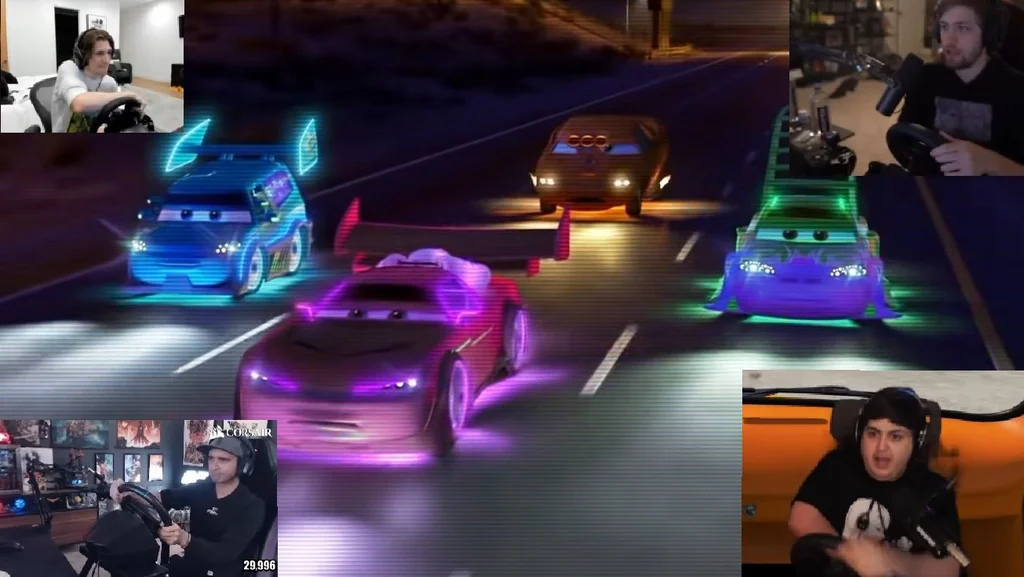

In [2]:
driving = Image.open("driving.png")
driving2 = io.imread('driving.png')
#print(driving)
#print(driving.format)
driving

In [3]:
driving2

array([[[ 69,  38,  19],
        [217, 183, 155],
        [209, 170, 129],
        ...,
        [ 43,  32,  27],
        [ 43,  32,  27],
        [ 42,  31,  26]],

       [[ 69,  38,  19],
        [217, 183, 155],
        [209, 170, 129],
        ...,
        [ 42,  31,  26],
        [ 42,  31,  26],
        [ 42,  31,  26]],

       [[ 69,  38,  19],
        [217, 183, 155],
        [209, 170, 129],
        ...,
        [ 42,  31,  26],
        [ 42,  31,  26],
        [ 42,  31,  26]],

       ...,

       [[187, 187, 191],
        [189, 188, 193],
        [193, 189, 195],
        ...,
        [ 86,  38,  11],
        [ 84,  38,  13],
        [ 80,  37,  10]],

       [[196, 193, 196],
        [197, 194, 198],
        [197, 194, 198],
        ...,
        [ 86,  38,   9],
        [ 84,  38,  11],
        [ 80,  37,  10]],

       [[203, 193, 199],
        [204, 196, 201],
        [196, 191, 195],
        ...,
        [ 86,  38,   9],
        [ 84,  38,  11],
        [ 81,  38,   9]]

In [4]:
print(driving)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x577 at 0x23F4FFB4F70>


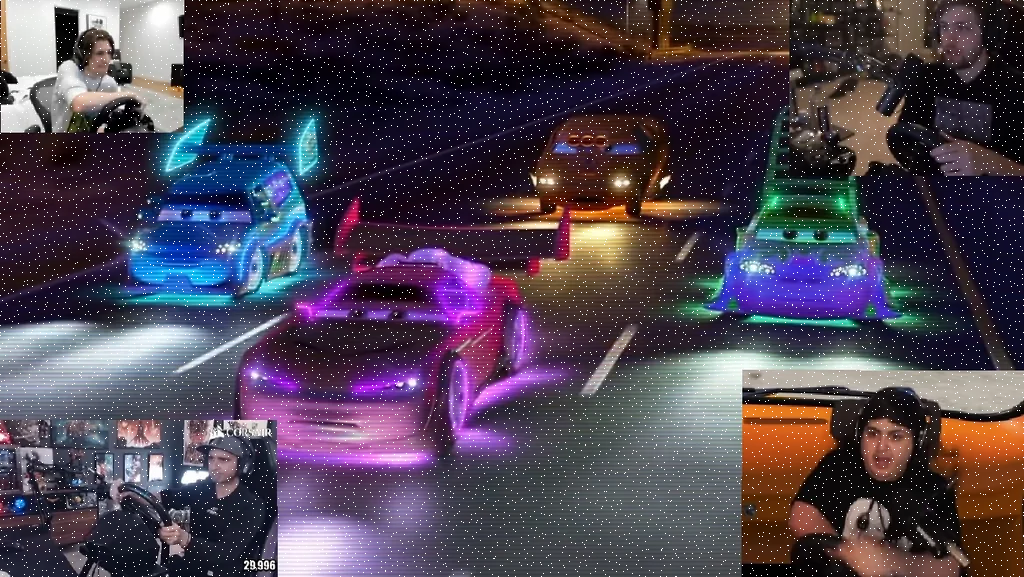

In [5]:
#How to decide which pixels are selected:
#If the number of pixels to be sampled is 100*k, then divide the number of pixels in the image by that value. Call
#the result n. Every nth pixel will be selected for sampling. To determine if pixel[i,j] is that nth pixel, do
# index = j*width + i to get the pixel index, then mod that value by n. If index % n = 0, you are on that pixel.

drivingOriginal = driving

toSample = 10000
random.seed(a=100) # the random seed should not be based on system time
k = 100
pixels = driving.load()
n = int(driving.size[0] * driving.size[1] / (k*100))
count = 0
size = 0
for i in range(0, driving.size[0], int(n**.5)):
    for j in range(0, driving.size[1], int(n**.5)):
        size = size+1
df_pixels = pd.DataFrame(columns=list('RGB'), index = np.arange(size))

for i in range(0, driving.size[0], int(n**.5)):
    for j in range(0, driving.size[1], int(n**.5)):
        i_ = i + random.randint(-3,3)
        if i_>=driving.size[0]:
            i_ = driving.size[0] - 1
        if i_<0:
            i_ = 0
        j_ = j + random.randint(-3,3)
        if j_>=driving.size[1]:
            j_ = driving.size[1] - 1
        if j_<0:
            j_ = 0
            
        df_pixels.iloc[[count]] = [[pixels[i_,j_][0], pixels[i_,j_][1], pixels[i_,j_][2]]]
        pixels[i_,j_] = (255,255,255)
        count = count + 1
driving

In [6]:
print(count)

12201


In [7]:
df_pixels

,R,G,B
0,69,38,19
1,79,39,23
2,79,40,15
3,87,46,14
4,106,62,25
...,...,...,...
12196,71,37,10
12197,75,39,10
12198,79,40,15
12199,82,39,13


Now that we have the RGB values of the sampled pixels in the dataset, we run K-means Clustering.
Options: different distance calculations. Euclidean and manhattan and some other one.
Do not force the centers.

In [13]:
df_sample = df_pixels.sample(n=k).reindex()
df_sample

,R,G,B
6025,89,34,82
5527,151,47,98
11157,14,9,29
7247,114,87,60
5911,15,11,35
...,...,...,...
11629,77,63,68
9661,26,97,107
9871,26,19,17
4561,136,116,170


In [14]:
kmeans = KMeans(n_clusters=100) #k
kmeans.fit(df_sample) #run on df_pixels

kmeans.labels_

array([35, 20, 66, 18, 93, 31,  5, 92, 65, 85, 74, 96, 16, 17, 10, 60, 28,
        4, 69, 40, 42, 49, 27, 95, 19, 52, 45,  2,  3, 12, 82, 33,  9, 72,
       53, 54, 37, 86,  6, 56, 24, 46, 98, 59, 22,  0, 25, 50, 81, 75, 38,
       68, 39, 73, 76, 14, 47, 61, 44, 84,  7, 70, 30,  1, 67, 91, 80, 11,
       79, 51, 32, 71, 23, 58, 77, 15, 97, 26, 63, 43,  8, 99, 57, 83, 41,
       64, 36, 89, 78, 88, 21, 62, 94, 48, 87, 34, 29, 55, 13, 90])

In [10]:
#kmeans.cluster_centers_[kmeans.labels_] 

In [20]:
joblib.dump(kmeans, 'kmeans.pkl')
kmeans_loaded = joblib.load('kmeans.pkl')

predicted = kmeans_loaded.predict([[37,17,31]])

In [21]:
kmeans.cluster_centers_[predicted] 

array([[37., 17., 31.]])

In [ ]:
#loop through whole image, predict the group that a pixel belongs in,
#switch the color of the pixel to it's cluster center, record the difference to keep track of variance within groups.